<a href="https://colab.research.google.com/github/danielahernandz/Series-de-tiempo-avanzado/blob/main/Hampel_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hampel Filter para detectar datos atipicos

Para cada observación de la variable o serie de tiempo X, se calcula la mediana de una ventana (un subconjunto de valores). Esa ventana va a estar compuesta por la observación en cuestión y por sus muestras circunsdantes, a cada lado. Luego estima la desviación estandar utilizando la medida llamada "mediana de la desviación absoluta con respecto a la mediana" que tambien se le conoce como MAD(median absolute deviation).

La idea es que su una muestra difiere de la mediana en más de K desviaciones estandar, se considera un dato atipico y se reemplaza por el valor de la mediana.

Usualmente se suele seleccionar k=3, lo que se conoce como la regla de las "3 sigmas". Esto depende del problema concreto.

Además entre el MAD y la desviación estandar se cumple la siguiente propiedad:

sigma= 1,4826

Para el filtro de Hampel necesitamos definir 2 propiedades:
1. El tamaño de la ventana(cuantos vecinos vamos a considerar)
2. El número de desviaciones para identificar a los atípicos (k).

Un umbral más alto hace que el filtro sea más tolerante, uno más bajo identificara más puntos como valores atipicos.

Referencia: Hampel F,R. "the influence curve and its role in robust estimation".


In [1]:
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np

## Creamos la función que me genera un Random Walk con outliers.

In [2]:
#ventana obervación y se tiene vecinos datos atras y adelante de la ventana o subconjunto de valores.

#esta función genera una serie simulada temporal y le agrega los atipicos
def random_walk_with_outliers(origin, n_steps, perc_outliers= 0.0, outlier_mult=10, seed= 42):
  assert (perc_outliers >= 0.0) & (perc_outliers <= 1.0)

  #set seed for reproducibility #establecer semilla para reproducibilidad
  np.random.seed(seed)

  #possible steps
  steps = [-1, 1]

  #simulate steps
  steps = np.random.choice(a=steps, size=n_steps-1)
  rw= np.append(origin, steps).cumsum(0)

  #add outliers /// se añede los atipicos
  n_outliers = int(np.round(perc_outliers * n_steps, 0))
  indices = np.random.randint(0, len(rw), n_outliers)
  rw[indices]= rw[indices] + steps[indices + 1]* outlier_mult

  return rw, indices

#Creamos los datos simulados

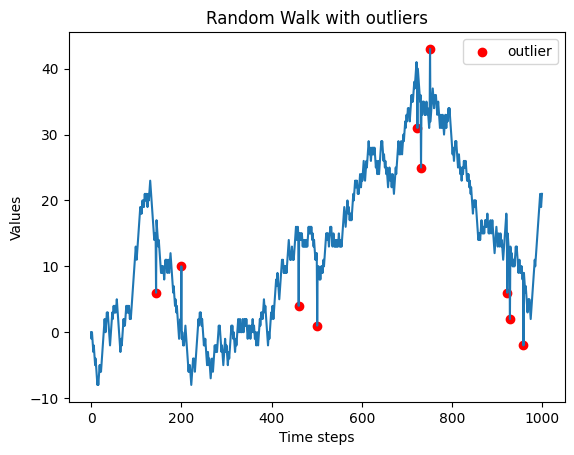

In [5]:
# me devuelve la serie con los atipicos, y me muestra cuales son los atipicos

rw, outliers_ind = random_walk_with_outliers(0, 1000, 0.01)
plt.plot(np.arange(len(rw)), rw)
plt.scatter(outliers_ind, rw[outliers_ind], c= 'r', label='outlier')
plt.title('Random Walk with outliers')
plt.xlabel('Time steps')
plt.ylabel('Values')
plt.legend();

#Creamos la función para evaluar la detección de los outliers (comparando los atipicos reales vs los atipicos detectados)

In [18]:
#comparando los atipicos que detecta el metodo con los verdaderos
def evaluate_detection(series, true_indices, detected_indices):
  #calculate metrics
  tp= list(set(detected_outliers).intersection(set(true_indices)))
  fp= list(set(detected_outliers).difference(set(true_indices)))
  fn= list(set(true_indices).difference(set(detected_indices)))
  perc_detected = 100 * len(tp) / len(true_indices)

  #create the plot
  fix, ax = plt.subplots(2, 1, figsize=(10,10))

  ax[0].plot(np.arange(len(series)), series);
  ax[0].scatter(true_indices, series[true_indices], c='g', label='true outlier' )
  # ax[0].set_title['Original series']
  ax[0].legend()

  ax[1].plot(np.arange(len(series)), series);
  ax[1].scatter(tp, series[tp], c='g', label='true positive' )
  ax[1].scatter(tp, series[tp], c='r', label='false positive' )
  ax[1].scatter(tp, series[tp], c='k', label='false positive' )
  # ax[1].set_title['Algorithm results']
  ax[1].legend()

  #print out summary
  print('-' * 25 + ' Summary' + '-' * 25)
  print(f'Outliers in the series: {len(true_indices)}')
  print(f'Identified outliers: {len(detected_indices)}')
  print(f'Correctly detected outliers: {len(tp)} ({perc_detected:.2f} % of all outliers).')
  print('-' * 59)

  return tp, fp, fn

#Hampel Filter



In [9]:
def hampel_filter_forloop(input_series, window_size, n_sigmas=3):
  n = len(input_series)
  new_series = input_series.copy()
  k = 1.4826 #scale factor for Gaussian distribution

  indices = []

  # possibly us np.nanmedian
  for i in range((window_size), (n - window_size)):
    x0 = np.median(input_series[(i - window_size): (i + window_size)])
    S0 = k * np.median(np.abs(input_series[(i - window_size): (i + window_size)] - x0))
    if (np.abs(input_series[i]- x0) > n_sigmas * S0):
      new_series[i] = x0
      indices.append(i)

  return new_series, indices

In [10]:
res, detected_outliers = hampel_filter_forloop(rw, 10)

In [12]:
detected_outliers

[144, 200, 265, 460, 501, 731, 751, 928, 958]

#Evaluación del resultado

------------------------- Summary-------------------------
Outliers in the series: 10
Identified outliers: 9
Correctly detected outliers: 8 (80.00 % of all outliers).
-----------------------------------------------------------


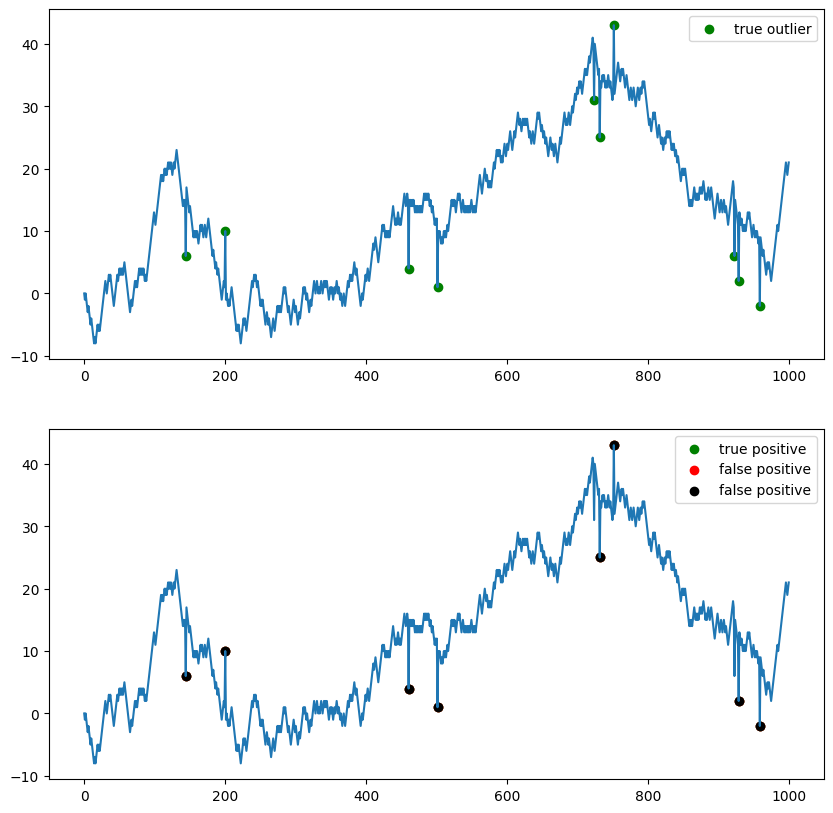

In [19]:
tp, fp, fn = evaluate_detection(rw, outliers_ind, detected_outliers)

#10  atipicos en la serie
#el metodo identifica 9 atipicos # 1 falso positivo se puede sustituir por la mediana
#los correctamente identificaddos son 8 # 2 valores que son atipicos que el metodo no detecta #2 falsos negativos mas preocuantes porque pueden desviar los resultados

#Serie de tiempo transformada despues de eliminar los atipicos

In [ ]:
plt.plot(np.arange(len(res)), res);
plt.scatter(outlier_ind, rw[outliers_ind], c='g', label='true outlier')
plt.scatter(fp, rw[fp], c='r', label='false positive')
plt.title('Cleaned series (without detected outliers)')
plt.legend();
